# Explore and Wrangling Data
**By: M. Alwi Sukra**

**Data exploration** is an approach similar to initial data analysis, whereby a data analyst uses visual exploration to understand what is in a dataset and the characteristics of the data, rather than through traditional data management systems. These characteristics can include size or amount of data, completeness of the data, correctness of the data, possible relationships amongst data elements or files/tables in the data.

**Data wrangling**, sometimes referred to as data munging, is the process of transforming and mapping data from one "raw" data form into another format with the intent of making it more appropriate and valuable for a variety of downstream purposes such as analytics.

#### import useful libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import time
from sklearn.preprocessing import MinMaxScaler

In [2]:
sns.set(rc={'figure.figsize':(16,14)})

#### import csv for all subject

In [3]:
CSV_PATH = "D:/datasets/ngantuk/csv/"
COLUMNS = ["subject","class_label","frame","rEar","lEar","mar"]
subjects = ["01", "02", "03", "04", "05", "06", "07", "08", "09", "10"]

In [4]:
dfs = []
for subject in subjects:
    path = CSV_PATH + subject + '.csv'
    dfs.append(pd.read_csv(path, names=COLUMNS, delimiter=";"))

In [5]:
df = pd.concat(dfs)

In [6]:
df.head()

,subject,class_label,frame,rEar,lEar,mar
0,1,0,1,0.256382,0.283467,0.028597
1,1,0,2,0.249904,0.236515,0.012574
2,1,0,3,0.156127,0.156127,0.018968
3,1,0,4,0.249904,0.242889,0.012192
4,1,0,5,0.285071,0.289970,0.019900


## Data Explore #1

So we have **10 subjects**, with **each subject have 2 class_label** which is class 0 (not-drowsy) and class 1 (drowsy). There is 3 numerical values in the dataset. The three value are `rEar`, `lEar`, `rEar`. So in this section, I want to visualize those data to take insight about the characteristic of the data.

#### boxplot for right eye aspect ratio

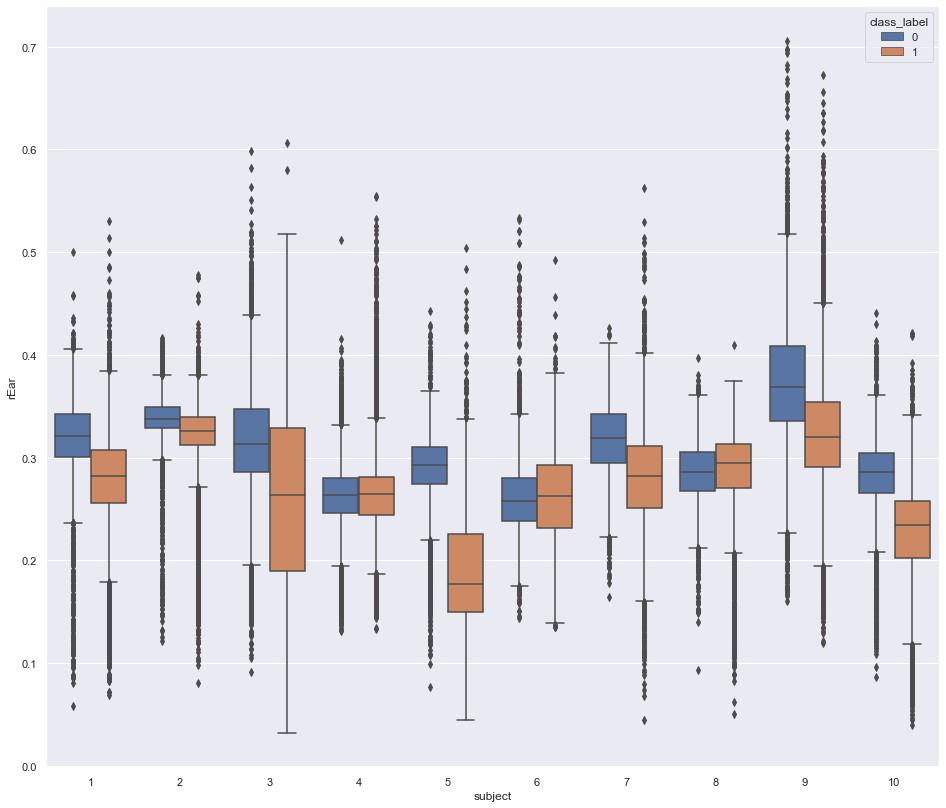

In [7]:
sns.boxplot(x='subject', y='rEar', data=df, hue='class_label')

From the above plot, we can see that **for majority subject, position of class 1 is lower than class 0**. This shows us that aspect ratio of eye in class 1 is often smaller. The smaller the aspect ratio, the more the eye closed. So we can give an assumption that the eye more often closed when in class 0 than in class 1. Another thing that we can see is the **inter quartile range is narrow and tend to be the same for all subjects**. This shows us that the stable opening aspect ratio for each subject has the same range.

#### boxplot for left eye aspect ratio

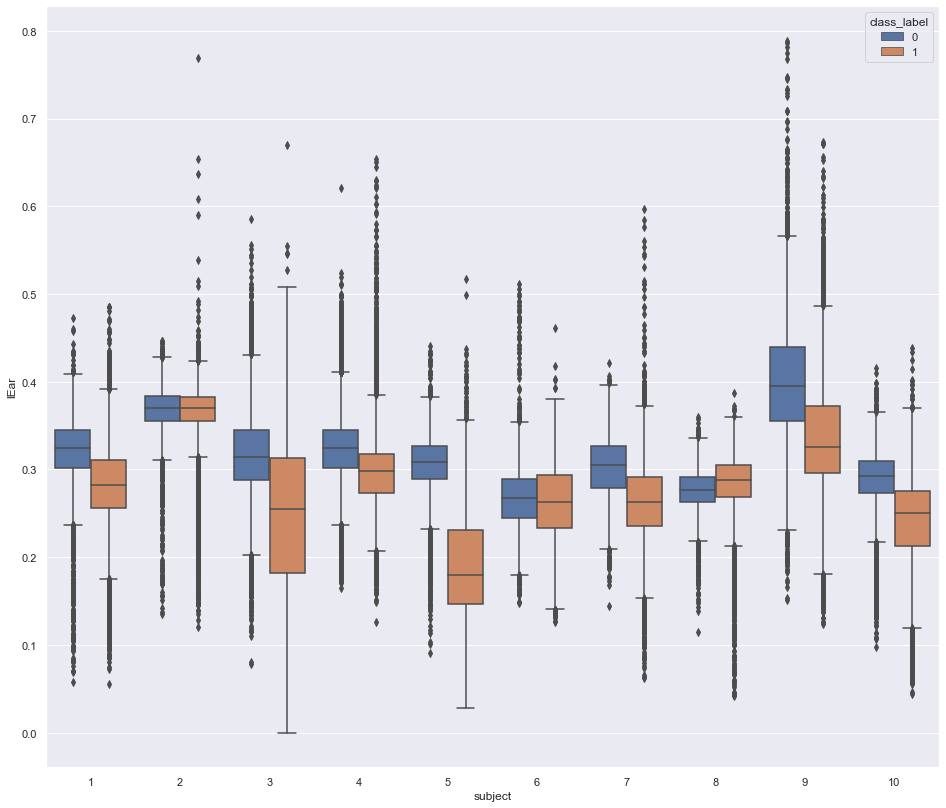

In [8]:
sns.boxplot(x='subject', y='lEar', data=df, hue='class_label')

From the above plot, we can see that **rEar and lEar is very simmilar**. This shows us that rEar and lEar is coupled.

#### boxplot for mouth aspect ratio

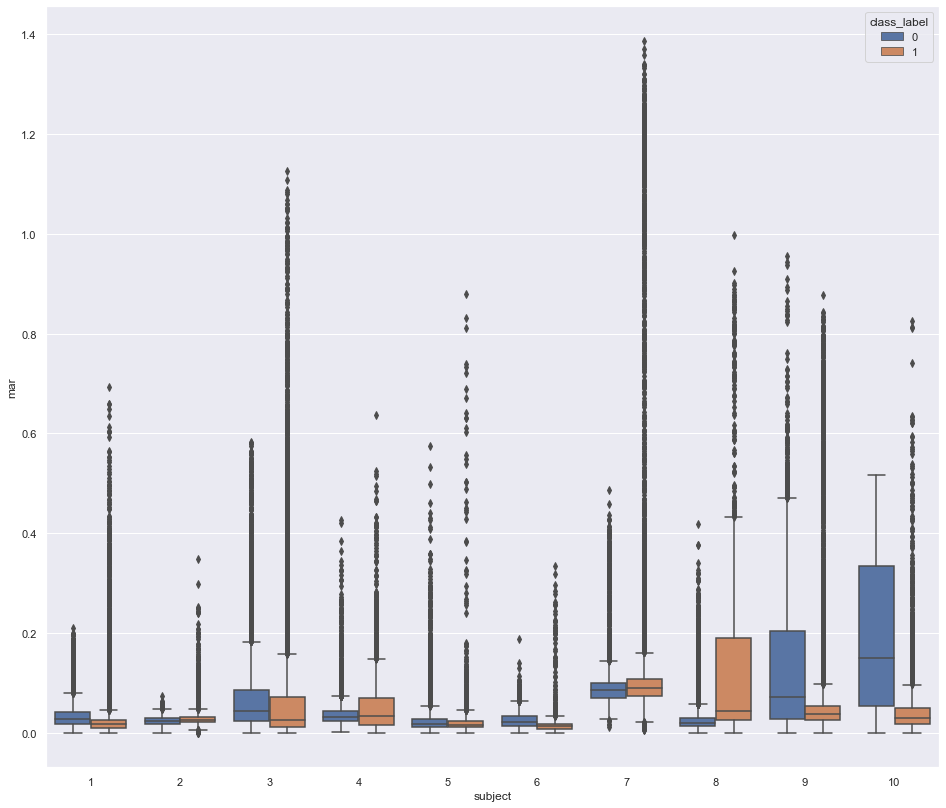

In [9]:
sns.boxplot(x='subject', y='mar', data=df, hue='class_label')

From the plot above, we can see that the **position of data is low close to 0**, this shows us that each subject rarely open their mouth. Another thing we can see is **position of data between two class in each subject is different with others, but in class 1 tend to be more upper outliers**. This show us that for each class, mouth is often closed, but in class 1 tend to be more extreme values which is large mouth opening.

## Data Wrangling #1

From previous section we already see the characteristic of the 3 numric values. There is **one problem that appear that is aspect ratio of each subject maybe doesn't mean the same to others subject even the aspect ratio is same**. **Features should be normalized across subjects if we are going to train the whole
data together at once**. Equation used to normalize feature is also used in [this paper](https://arxiv.org/pdf/1904.07312.pdf). They use the first third of the feature of the alert state to compute the mean and standard deviation of each feature for each individual, and then use that values to normalize the rest.

#### define equation

In [10]:
def normalize(input_df, fps, minutes_length):
    calibration_frame = int(fps * 60 * minutes_length)
    # compute mean and std
    means = input_df.loc[(input_df["frame"] > 0) & (input_df["frame"] <= calibration_frame)].mean()
    stds = input_df.loc[(input_df["frame"] > 0) & (input_df["frame"] <= calibration_frame)].std()
    # normalize
    input_df['rEar_norm'] = (input_df['rEar'] - means['rEar']) / stds['rEar']
    input_df['lEar_norm'] = (input_df['lEar'] - means['lEar']) / stds['lEar']
    input_df['mar_norm'] = (input_df['mar'] - means['mar']) / stds['mar']
    return input_df, means, stds

#### get FPS info

We need fps information for each subject's video, so that we can do calculation on the first 2 minutes

In [11]:
FPS_PATH = "D:/datasets/ngantuk/fps_info.txt"

In [12]:
df_fps = pd.read_csv(FPS_PATH, names=['subject','class_label','fps'], delimiter=';', index_col=False)
df_fps.head()

,subject,class_label,fps
0,1,0,24.91
1,1,1,24.91
2,2,0,30.00
3,2,1,30.00
4,3,0,30.03


#### normalize value

In [13]:
MINUTES_LENGTH = 2

In [14]:
dfs_normalize = []
statistics = []
for subject, df_subject in df.groupby('subject'):
    _df = pd.DataFrame(df_subject)
    # get fps for class 0
    fps = df_fps.loc[(df_fps['subject'] == subject) & (df_fps['class_label'] == 0)]['fps'].values[0]
    # normalize
    _df, means, stds = normalize(_df, fps, MINUTES_LENGTH)
    statistics.append([subject, means['rEar'], means['lEar'], means['mar'], stds['rEar'], stds['lEar'], stds['mar']])
    dfs_normalize.append(_df)

In [15]:
df_normalize = pd.concat(dfs_normalize)

In [16]:
df_normalize.head()

,subject,class_label,frame,rEar,lEar,mar,rEar_norm,lEar_norm,mar_norm
0,1,0,1,0.256382,0.283467,0.028597,-0.628895,-0.139827,-0.143620
1,1,0,2,0.249904,0.236515,0.012574,-0.745600,-0.983425,-0.385401
2,1,0,3,0.156127,0.156127,0.018968,-2.435053,-2.427776,-0.288919
3,1,0,4,0.249904,0.242889,0.012192,-0.745600,-0.868902,-0.391171
4,1,0,5,0.285071,0.289970,0.019900,-0.112044,-0.022986,-0.274847


In [17]:
df_normalize.describe()

,subject,class_label,frame,rEar,lEar,mar,rEar_norm,lEar_norm,mar_norm
count,173067.000000,173067.000000,173067.000000,167766.000000,167766.000000,167766.000000,167766.000000,167766.000000,167766.000000
mean,4.953954,0.504348,5166.032011,0.295372,0.308822,0.064781,-0.006334,0.027934,-0.027110
std,2.851668,0.499983,3734.707824,0.058980,0.066904,0.104754,1.034230,1.054690,1.027625
min,1.000000,0.000000,1.000000,0.032258,0.000000,0.000000,-8.529389,-8.045033,-2.913086
25%,2.000000,0.000000,2164.000000,0.263130,0.271318,0.018445,-0.512567,-0.516557,-0.532154
50%,4.000000,1.000000,4555.000000,0.299948,0.308592,0.030670,0.082267,0.120934,-0.291984
75%,7.000000,1.000000,7419.000000,0.333067,0.351975,0.067966,0.618877,0.663662,0.164061
max,10.000000,1.000000,18446.000000,0.705754,0.788566,1.386670,9.551358,13.226006,36.969787


In [18]:
df_statistic = pd.DataFrame(statistics, columns=['subject','mean_rEar','mean_lEar','mean_mar','std_rEar','std_lEar','std_mar'])

In [19]:
df_statistic.head()

,subject,mean_rEar,mean_lEar,mean_mar,std_rEar,std_lEar,std_mar
0,1,0.291290,0.291249,0.038115,0.055507,0.055657,0.066271
1,2,0.331725,0.365555,0.025425,0.029387,0.030480,0.008728
2,3,0.298865,0.293354,0.080800,0.069526,0.067990,0.131152
3,4,0.255562,0.297604,0.037324,0.031327,0.037948,0.030768
4,5,0.247106,0.256431,0.033043,0.064057,0.071658,0.059765


## Data Explore #2

In the previous section, we got 3 additional features `rEar_norm`, `lEar_norm`, `rEar_norm` which is the normalize value of `rEar`, `lEar`, `rEar`. In this section **we want to visualize the data to check if we successfuly normalized features** accross the subjects

#### boxplot for normalized right eye aspect ratio

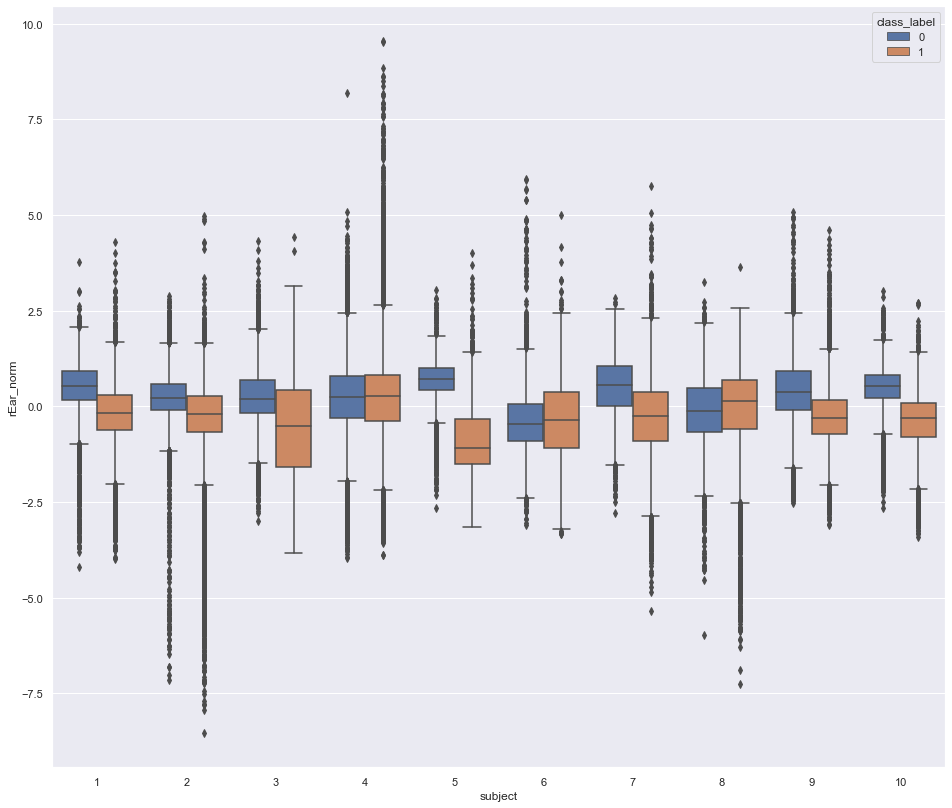

In [20]:
sns.boxplot(x='subject', y='rEar_norm', data=df_normalize, hue='class_label')

#### boxplot for normalized left eye aspect ratio

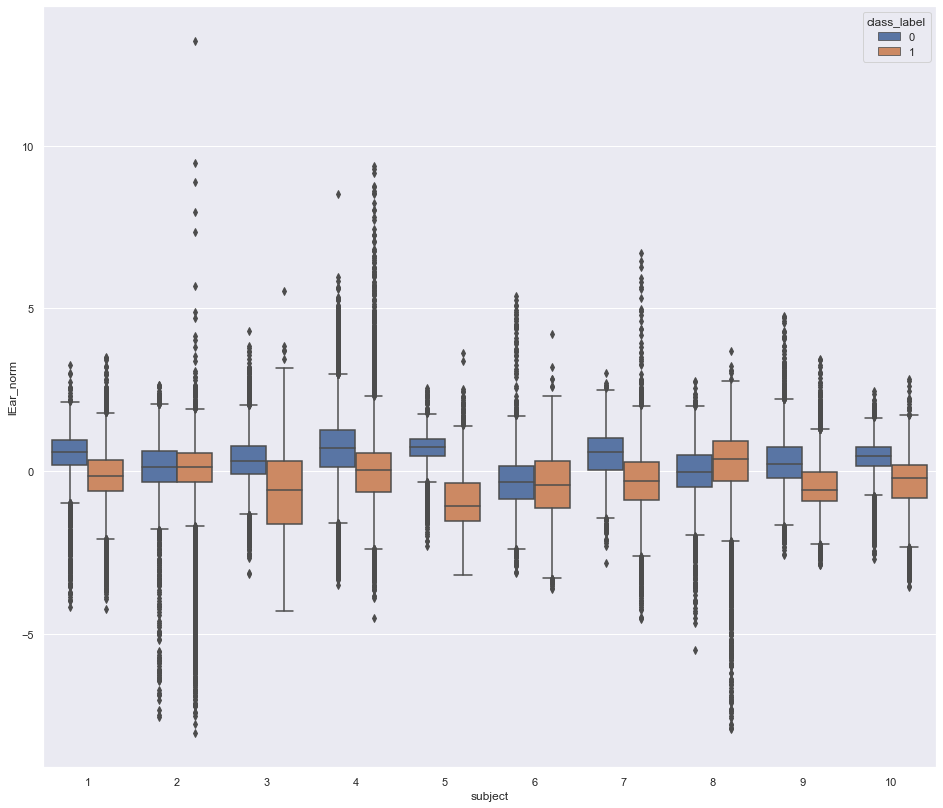

In [21]:
sns.boxplot(x='subject', y='lEar_norm', data=df_normalize, hue='class_label')

#### boxplot for normalized mouth aspect ratio

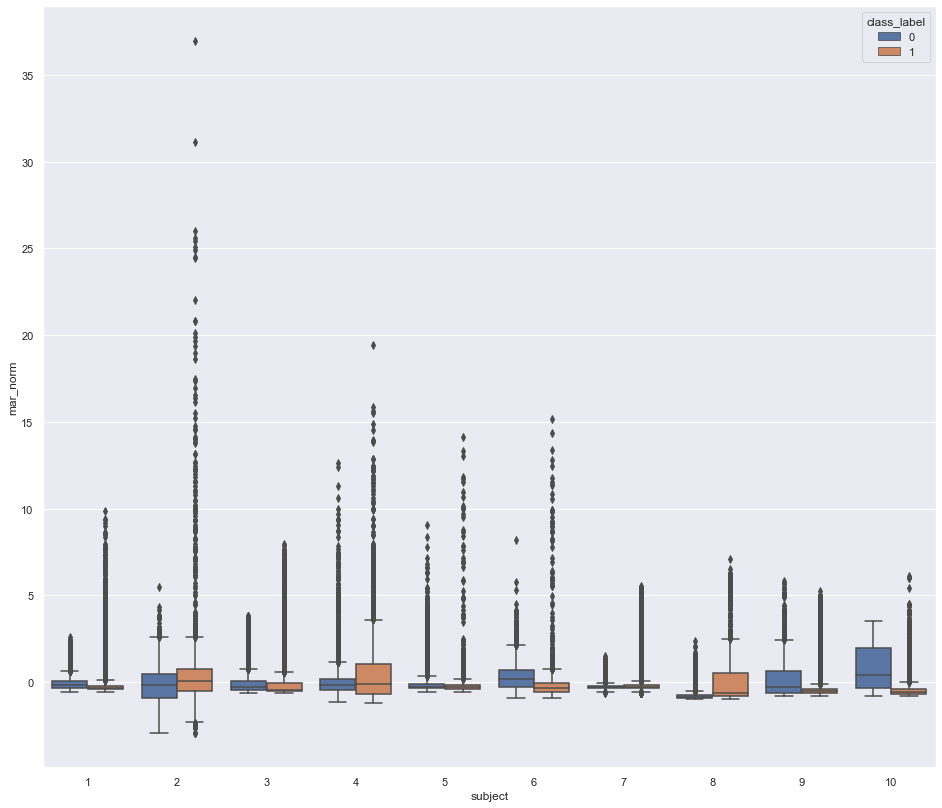

In [22]:
sns.boxplot(x='subject', y='mar_norm', data=df_normalize, hue='class_label')

From the above three plots. We can see that **we successfully normalized data** accross subjects. We can say that because, as we can see, now **position of the data tend to be the same** accross subjects (excluding outliers). So, the same aspect ratio accross subject approximately say the same condition.

## Data Wrangling #2

The normalized value is not scale between 0-1, so in this section we want to **scale it to 0-1**. But, before scaling, we can see that in some subject the outliers is to extreme if we compare it to another subject. So we want to deal with it first

#### Scaling value

In [23]:
maxEar = 5.5
minEar = -5.5
maxMar = 15
minMar = -1.5

In [24]:
df_normalize.loc[df_normalize['rEar_norm'] > maxEar, 'rEar_norm'] = maxEar
df_normalize.loc[df_normalize['rEar_norm'] < minEar, 'rEar_norm'] = minEar
df_normalize.loc[df_normalize['lEar_norm'] > maxEar, 'lEar_norm'] = maxEar
df_normalize.loc[df_normalize['lEar_norm'] < minEar, 'lEar_norm'] = minEar
df_normalize.loc[df_normalize['mar_norm'] > maxMar, 'mar_norm'] = maxMar
df_normalize.loc[df_normalize['mar_norm'] < minMar, 'mar_norm'] = minMar

In [25]:
print(f"MAX rEar norm: {df_normalize.describe()['rEar_norm']['max']}")
print(f"MIN rEar norm: {df_normalize.describe()['rEar_norm']['min']}")
print(f"MAX lEar norm: {df_normalize.describe()['lEar_norm']['max']}")
print(f"MIN lEar norm: {df_normalize.describe()['lEar_norm']['min']}")  
print(f"MAX mar norm: {df_normalize.describe()['mar_norm']['max']}")
print(f"MIN mar norm: {df_normalize.describe()['mar_norm']['min']}")  

MAX rEar norm: 5.5
MIN rEar norm: -5.5
MAX lEar norm: 5.5
MIN lEar norm: -5.5
MAX mar norm: 15.0
MIN mar norm: -1.5


In [26]:
scaler = MinMaxScaler(feature_range=(0,1))

In [27]:
df_normalize[['rEar_norm','lEar_norm','mar_norm']] = scaler.fit_transform(df_normalize[['rEar_norm','lEar_norm','mar_norm']])

In [28]:
df_normalize.head()

,subject,class_label,frame,rEar,lEar,mar,rEar_norm,lEar_norm,mar_norm
0,1,0,1,0.256382,0.283467,0.028597,0.442828,0.487288,0.082205
1,1,0,2,0.249904,0.236515,0.012574,0.432218,0.410598,0.067551
2,1,0,3,0.156127,0.156127,0.018968,0.278632,0.279293,0.073399
3,1,0,4,0.249904,0.242889,0.012192,0.432218,0.421009,0.067202
4,1,0,5,0.285071,0.289970,0.019900,0.489814,0.497910,0.074252


## Data Explore #3

We want to see **if data scaled successfully**. Another thing that **we want to see is how many NaN values for each subject's videos** so we can take further actions.

#### boxplot for normalized right eye aspect ratio

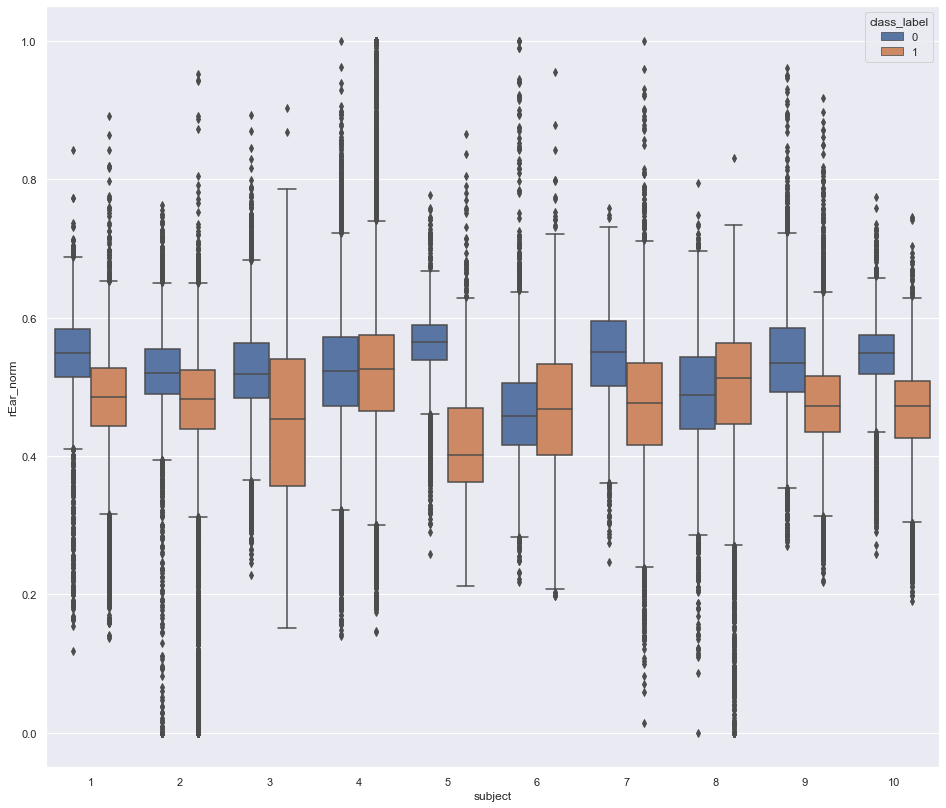

In [29]:
sns.boxplot(x='subject', y='rEar_norm', data=df_normalize, hue='class_label')

#### boxplot for normalized left eye aspect ratio

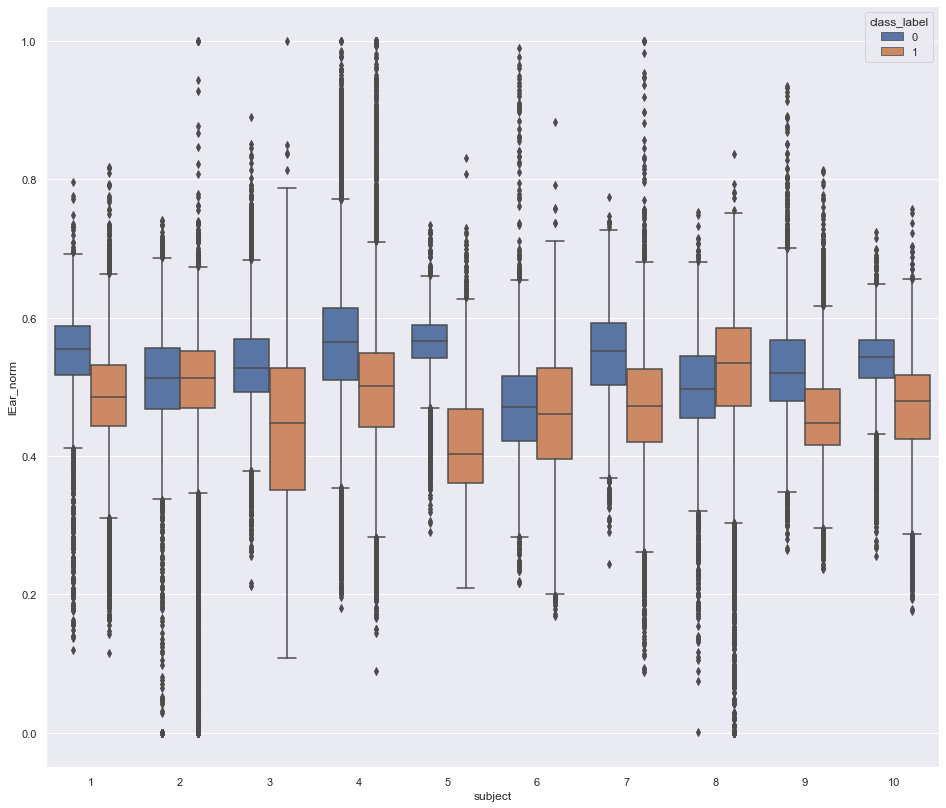

In [30]:
sns.boxplot(x='subject', y='lEar_norm', data=df_normalize, hue='class_label')

#### boxplot for normalized mouth aspect ratio

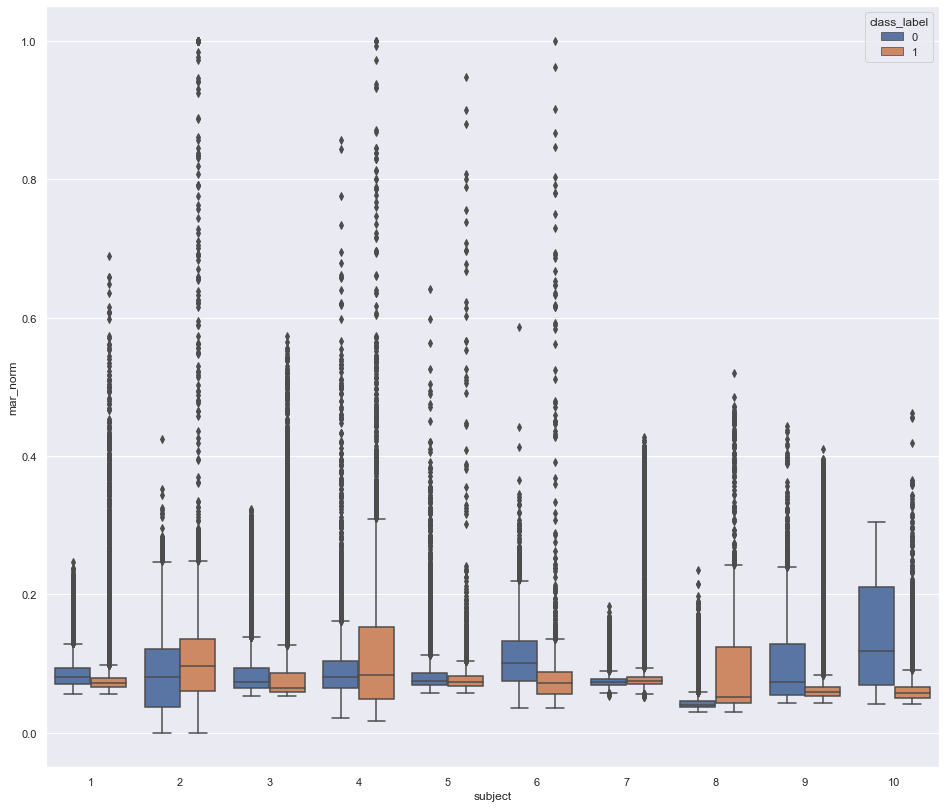

In [31]:
sns.boxplot(x='subject', y='mar_norm', data=df_normalize, hue='class_label')

As we can see from the above 3 plot, **we successfully scaled the data**

#### check for null value (NaN)

In [32]:
nan_ratio = []
for subject, df_subject in df_normalize.groupby('subject'):
    _df = pd.DataFrame(df_subject)
    length = len(_df)
    nan_counts = _df.isna().sum()
    # [subject, ratio nan rEar, ratio nan lEar, ratio nan mAr]
    nan_ratio.append([subject, nan_counts['rEar_norm']/length, nan_counts['lEar_norm']/length, nan_counts['mar_norm']/length])

In [33]:
df_nan_ratio = pd.DataFrame(nan_ratio, columns=['subject','rEar_nan_ratio','lEar_nan_ratio','mar_nan_ratio'])

In [34]:
sns.set(rc={'figure.figsize':(8,6)})

Ratio of rEar with NaN values for each subjects

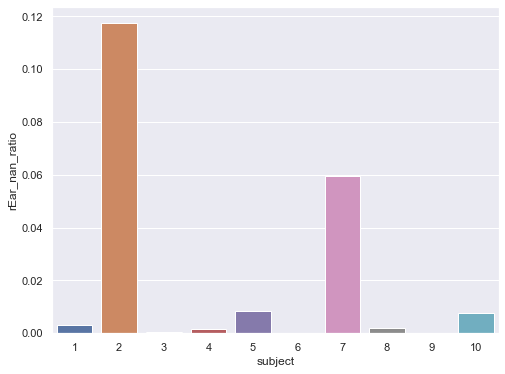

In [35]:
sns.barplot(x='subject', y='rEar_nan_ratio', data=df_nan_ratio)

Ratio of lEar with NaN values for each subjects

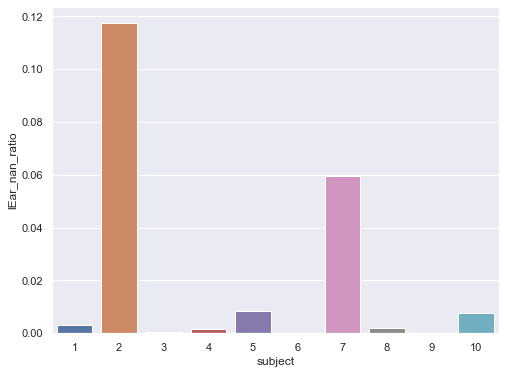

In [36]:
sns.barplot(x='subject', y='lEar_nan_ratio', data=df_nan_ratio)

Ratio of mar with NaN values for each subjects

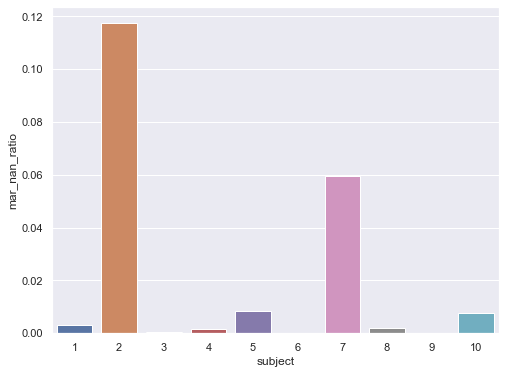

In [37]:
sns.barplot(x='subject', y='mar_nan_ratio', data=df_nan_ratio)

From the above three plots, we can see that the **ratio of missing values is the same between the 3 features**. Another thing we can see is the **NaN values is tends to be small and even does not exist at all**.

## Data Wrangling #3

From previous section, we can see that **our dataset contains NaN values**. these values can affect our analysis so we must take further actions to overcome this. On of the way to solve this problem is by filling the NaN values with data. **One method that can be use to fill NaN values is interpolate**.

#### drop unused columns

In [38]:
df_normalize.drop(columns=['rEar','lEar','mar'], inplace=True)

In [39]:
df_normalize.head()

,subject,class_label,frame,rEar_norm,lEar_norm,mar_norm
0,1,0,1,0.442828,0.487288,0.082205
1,1,0,2,0.432218,0.410598,0.067551
2,1,0,3,0.278632,0.279293,0.073399
3,1,0,4,0.432218,0.421009,0.067202
4,1,0,5,0.489814,0.497910,0.074252


#### fill missing values

In [40]:
df_normalize.interpolate(inplace=True)

check

In [41]:
for subject, df_subject in df_normalize.groupby('subject'):
    _df = pd.DataFrame(df_subject)
    print(f"for subject {subject} there is {_df.isna().sum()['rEar_norm']} missing values")

for subject 1 there is 0 missing values
for subject 2 there is 0 missing values
for subject 3 there is 0 missing values
for subject 4 there is 0 missing values
for subject 5 there is 0 missing values
for subject 6 there is 0 missing values
for subject 7 there is 0 missing values
for subject 8 there is 0 missing values
for subject 9 there is 0 missing values
for subject 10 there is 0 missing values


## Data Explore #4

After previous section, now our datasets doesn't contains anymore NaN values. In this section **we want to know the correlation of features with class_label**.

#### matrix correlation

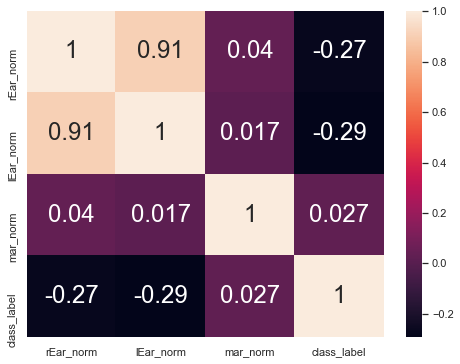

In [42]:
sns.heatmap(df_normalize[['rEar_norm','lEar_norm','mar_norm','class_label']].corr(), annot=True, annot_kws={'size':24})

From the above plot, we can see that **all features we have currently have a not so good correlation with the label**. 

## Data Wrangling #4

As we already know, **aspect ratio can determine the condition of our eyes and mouth** whether it is open or closed. So, in this section **we want to calculate the state of eye and mouth based on aspect ratio values**. We can do this by set a **threshold value**. 

**BUT, there is no standard threshold values** for aspect ratio so **i have to test several threshold values and decide which threshold value works best**. To do that, i create a [c++ program](https://github.com/Arkoes07/random-sample-labelling) to **take a random 100 frame for each subject** (50 frame per class) and display, then i have to **decide whether the eye open or closed**. The state that i choose become the **state label that used in this section to calculate the accuracy** for each threshold values.

#### get state label for mouth and eye from random sample

In [43]:
LABEL_CSV_PATH = "D:/datasets/ngantuk/random_sample/"
LABEL_COLUMNS = ["subject","class_label","frame","eye_state","mouth_state"]
subjects = ["01", "02", "03", "04", "05", "06", "07", "08", "09", "10"]

In [44]:
dfs_state_label = []
for subject in subjects:
    path = LABEL_CSV_PATH + subject + '.csv'
    dfs_state_label.append(pd.read_csv(path, names=LABEL_COLUMNS, delimiter=";", index_col=False))

In [45]:
df_state_label = pd.concat(dfs_state_label)

In [46]:
df_state_label.head()

,subject,class_label,frame,eye_state,mouth_state
0,1,0,1,1,0
1,1,0,3,0,0
2,1,0,95,1,0
3,1,0,237,1,0
4,1,0,256,1,0


#### merge random sample so that it contains generated feature 

In [47]:
df_merged = pd.merge(df_state_label,df_normalize, on=['subject','class_label','frame'])

In [48]:
df_merged.head(5)

,subject,class_label,frame,eye_state,mouth_state,rEar_norm,lEar_norm,mar_norm
0,1,0,1,1,0,0.442828,0.487288,0.082205
1,1,0,3,0,0,0.278632,0.279293,0.073399
2,1,0,95,1,0,0.568857,0.575896,0.070335
3,1,0,237,1,0,0.494497,0.529276,0.065431
4,1,0,256,1,0,0.568679,0.575509,0.086373


#### find the best threshold for eye and mouth

In [49]:
THRESHOLDS = [t/1000 for t in range (100,601,20)]

In [50]:
accuracys = []

In [51]:
for threshold in THRESHOLDS:
    _df = pd.DataFrame(df_merged)
     # default value
    _df['calc_eye_state'] = 1
    _df['calc_mouth_state'] = 0
    # check if eye closed and mouth open
    _df.loc[(_df['rEar_norm'] < threshold) & (_df['lEar_norm'] < threshold), 'calc_eye_state'] = 0
    _df.loc[_df['mar_norm'] > threshold, 'calc_mouth_state'] = 1
    # check correctness
    _df['is_eye_correct'] = 0
    _df['is_mouth_correct'] = 0
    _df.loc[_df['eye_state'] == _df['calc_eye_state'], 'is_eye_correct'] = 1
    _df.loc[_df['mouth_state'] == _df['calc_mouth_state'], 'is_mouth_correct'] = 1
    #check accuracy
    for subject, df_subject in _df.groupby('subject'):
        value_sum = df_subject.sum()
        length = len(df_subject)
        accuracys.append([threshold, subject, value_sum['is_eye_correct'], value_sum['is_mouth_correct']])

In [52]:
df_threshold_accuracy = pd.DataFrame(accuracys, columns=['threshold','subject','eye_state_accuracy','mouth_state_accuracy'])

## Data Explore #5

In the previous section, we calculate the accuracy of each subject in deciding whether the eye and mouth opened or closed. In this section **we want to visualize the result we got from previous section** so we can see and **choose which threshold value work best** in deciding the state of eye and mouth.

#### visualize accuracy

In [53]:
sns.set(rc={'figure.figsize':(18,6)})

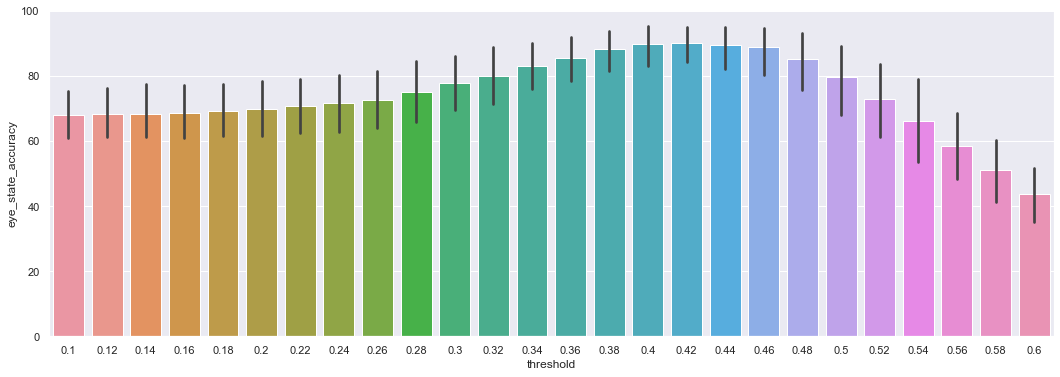

In [54]:
sns.barplot(x="threshold",y="eye_state_accuracy",data=df_threshold_accuracy)

For eye, **threshold that work best is 0.42** with the highest accuracy and small confidence interval with the highest minimum.

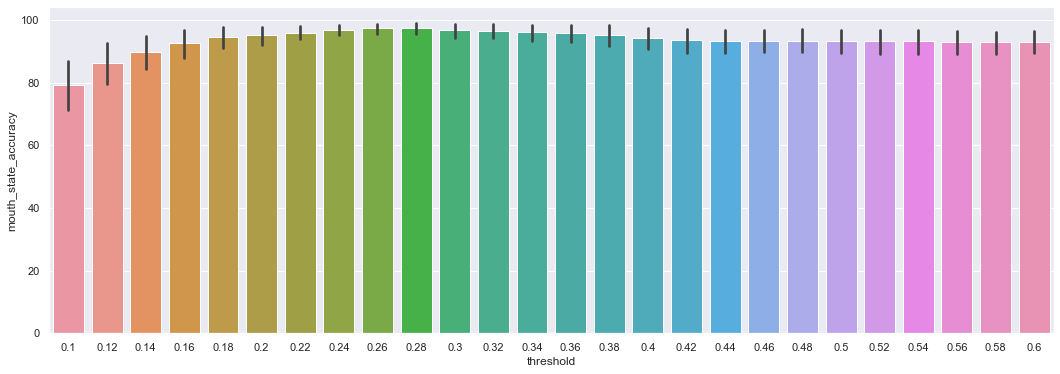

In [55]:
sns.barplot(x="threshold",y="mouth_state_accuracy",data=df_threshold_accuracy)

For mouth, **threshold that work best is 0.26** with the highest accuracy and small confidence interval with the highest minimum.

In [56]:
df_normalize.head()

,subject,class_label,frame,rEar_norm,lEar_norm,mar_norm
0,1,0,1,0.442828,0.487288,0.082205
1,1,0,2,0.432218,0.410598,0.067551
2,1,0,3,0.278632,0.279293,0.073399
3,1,0,4,0.432218,0.421009,0.067202
4,1,0,5,0.489814,0.497910,0.074252


## Data Wrangling #5

In the previous section we already got the best threshold values. So in this section **we want to calculate the state of the eye and mouth**. Zero and one is used to represent the state with **0 = closed and 1 = opened**

#### choose the best threshold for both eye and mouth

In [57]:
EYE_THRESHOLD = 0.42
MOUTH_THRESHOLD = 0.26

#### calculate state of eye and mouth

In [58]:
df_state = pd.DataFrame(df_normalize)

In [59]:
# default value
df_state['calc_eye_state'] = 1
df_state['calc_mouth_state'] = 0
# check if eye closed and mouth open
df_state.loc[(df_state['rEar_norm'] < EYE_THRESHOLD) | (df_state['lEar_norm'] < EYE_THRESHOLD), 'calc_eye_state'] = 0
df_state.loc[df_state['mar_norm'] > MOUTH_THRESHOLD, 'calc_mouth_state'] = 1

In [60]:
df_state[4484:4490]

,subject,class_label,frame,rEar_norm,lEar_norm,mar_norm,calc_eye_state,calc_mouth_state
4484,1,0,4485,0.576412,0.601768,0.210735,1,0
4485,1,0,4486,0.498003,0.554422,0.201034,1,0
4486,1,0,4487,0.595975,0.581950,0.208411,1,0
4487,1,0,4488,0.549539,0.534910,0.200352,1,0
4488,1,0,4489,0.549367,0.593125,0.187592,1,0
4489,1,0,4490,0.549367,0.574782,0.223025,1,0


## Data Explore #6

From the previous section we get 2 additional features `calc_eye_state` and `calc_mouth_state` which represent the state of the eye and mouth whether it is opened or closed. In this section **we want to know the correlation those new features with class label**.

#### matrix correlation

In [61]:
sns.set(rc={'figure.figsize':(8,6)})

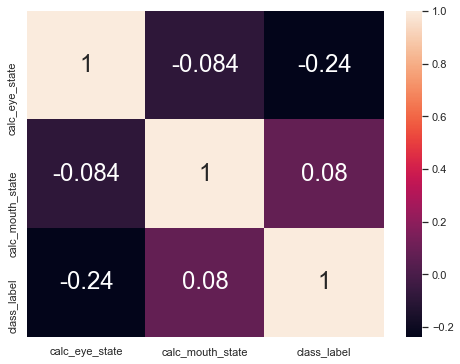

In [62]:
sns.heatmap(df_state[['calc_eye_state','calc_mouth_state','class_label']].corr(), annot=True, annot_kws={'size':24})

From the above plot, we can see that **the features also have a not so good correlation with the label**. this is **acceptable** because this **state is directly related to aspect ratio**. So it will make much difference.

## Data Wrangling #6

From the previous section, we know that the features we have currently have a not so good correlation with the label. So in this section, **we want to make use of available features to generated a more useful features**. The features we will generate is **PERCLOS** which is percentage of eye close in some time,  **microsleep rate** which is the rate of microsleep occured in some time, and **yawning rate** which is the rate of yawning occured in some time.

In this section, we will **produce 2 DataFrame**, **one with original fps** value according to the subjects video (for ANN model), and **the other with identical FPS** accross subjects (for LSTM model).

#### Define function to generate aggregate features

In [63]:
def change_fps(df, fps, to_fps):
    step = int(fps/to_fps)
    df_step = df.iloc[::step]
    df_step.reset_index(inplace=True)
    df_step.index = pd.RangeIndex(1, len(df_step)+1, 1)
    return pd.DataFrame(df_step)

In [64]:
def calculate_perclos(_df, window_size):
    start_frame = 1
    for current_idx in range(window_size+1,len(_df)+1):
        stop_frame = current_idx - 1
        _df.loc[current_idx,'perclos'] = _df.loc[start_frame:stop_frame,'calc_eye_state'].eq(0).sum() / window_size
        start_frame = start_frame + 1  
    return _df

In [65]:
def track_consecutive(_df):
    val_dict = dict([(0, 1), (1, 0)])
    # inverse
    _df['calc_eye_state'].replace(val_dict, inplace=True)
    eye = _df['calc_eye_state']
    mouth = _df['calc_mouth_state']
    _df['btb_eye_closed'] = 0
    _df['btb_mouth_opened'] = 0
    _df['btb_eye_closed'] = eye * (eye.groupby((eye != eye.shift()).cumsum()).cumcount() + 1)
    _df['btb_mouth_opened'] = mouth * (mouth.groupby((mouth != mouth.shift()).cumsum()).cumcount() + 1)
    # inverse so that value same as the first
    _df['calc_eye_state'].replace(val_dict, inplace=True)
    return _df

In [66]:
def calculate_event_rate(_df, window_size, fps, btb_microsleep, btb_yawning):
    start_frame = 1
    for current_idx in range(window_size+1,len(_df)+1):
        stop_frame = current_idx - 1
        _df.loc[current_idx,'microsleep_rate'] = _df.loc[start_frame:stop_frame,'btb_eye_closed'].eq(btb_microsleep).sum() / (window_size/fps)
        _df.loc[current_idx,'yawning_rate'] = _df.loc[start_frame:stop_frame,'btb_mouth_opened'].eq(btb_yawning).sum() / (window_size/fps)
        start_frame = start_frame + 1  
    return _df

In [67]:
def feature(_df, fps, minutes_length, btb_microsleep_second, btb_yawning_second):
    window_size = int(fps * 60 * minutes_length)
    _df = calculate_perclos(_df, window_size)
    _df = track_consecutive(_df)
    btb_microsleep = btb_microsleep_second * fps
    btb_yawning = btb_yawning_second * fps
    _df = calculate_event_rate(_df, window_size, fps, btb_microsleep, btb_yawning)
    _df.drop(['btb_eye_closed', 'btb_mouth_opened'], axis=1, inplace=True)
    _df.dropna(inplace=True)
    return _df

#### feature engineering

In [68]:
MINUTES_LENGTH = 3
BTB_MICROSLEEP_SECOND = 1
BTB_YAWNING_SECOND = 5
NEW_FPS = 8

In [69]:
%%time
aggregates = []
aggregates_identical_fps = []

for subject, df_subject in df_state.groupby('subject'):
    for class_label, df_class in df_subject.groupby('class_label'):
        # DataFrame for each class
        __df = pd.DataFrame(df_class).set_index('frame')
        # get fps for this subject and class
        fps = df_fps.loc[(df_fps["class_label"] == class_label) & (df_fps["subject"] == subject)].fps.values[0]
        
        __df_identical = change_fps(__df, fps, NEW_FPS)
        
        # feature engineering
        __df = feature(__df, fps, MINUTES_LENGTH, BTB_MICROSLEEP_SECOND, BTB_YAWNING_SECOND)
        __df_identical = feature(__df_identical, NEW_FPS, MINUTES_LENGTH, BTB_MICROSLEEP_SECOND, BTB_YAWNING_SECOND)
        aggregates.append(__df)
        aggregates_identical_fps.append(__df_identical)

Wall time: 6min 16s


In [70]:
df_aggregate = pd.concat(aggregates)
df_aggregate_identical_fps = pd.concat(aggregates_identical_fps)

In [71]:
df_aggregate.reset_index(inplace=True)
df_aggregate_identical_fps.reset_index(inplace=True, drop=True)

In [72]:
df_aggregate.head()

,frame,subject,class_label,rEar_norm,lEar_norm,mar_norm,calc_eye_state,calc_mouth_state,perclos,microsleep_rate,yawning_rate
0,4484,1,0,0.582719,0.622472,0.216977,1,0,0.033683,0.0,0.0
1,4485,1,0,0.576412,0.601768,0.210735,1,0,0.033683,0.0,0.0
2,4486,1,0,0.498003,0.554422,0.201034,1,0,0.033460,0.0,0.0
3,4487,1,0,0.595975,0.581950,0.208411,1,0,0.033237,0.0,0.0
4,4488,1,0,0.549539,0.534910,0.200352,1,0,0.033237,0.0,0.0


In [73]:
df_aggregate_identical_fps.head()

,frame,subject,class_label,rEar_norm,lEar_norm,mar_norm,calc_eye_state,calc_mouth_state,perclos,microsleep_rate,yawning_rate
0,4321,1,0,0.535363,0.553641,0.098949,1,0,0.030556,0.0,0.0
1,4324,1,0,0.547988,0.562705,0.083339,1,0,0.030556,0.0,0.0
2,4327,1,0,0.576507,0.554961,0.112021,1,0,0.030556,0.0,0.0
3,4330,1,0,0.555828,0.533281,0.085486,1,0,0.030556,0.0,0.0
4,4333,1,0,0.535523,0.520933,0.084005,1,0,0.030556,0.0,0.0


## Data Explore #7

From the previous section we got 3 additional features which is `perclos`, `microsleep_rate`, and `yawning_rate`. in this section **we want to visualize the new generated features** (just for the original fps dataframe).

In [74]:
sns.set(rc={'figure.figsize':(12,10)})

#### boxplot for perclos

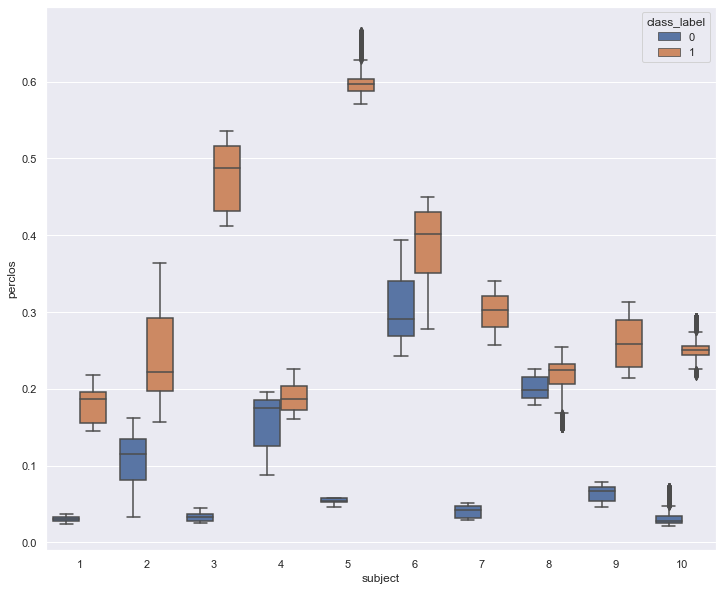

In [75]:
sns.boxplot(x='subject', y='perclos', data=df_aggregate, hue='class_label')

From the above plot, we can see that **for majority subjects, perclos in class 1 is bigger than perclos in class 0**.

#### boxplot for microsleep rate

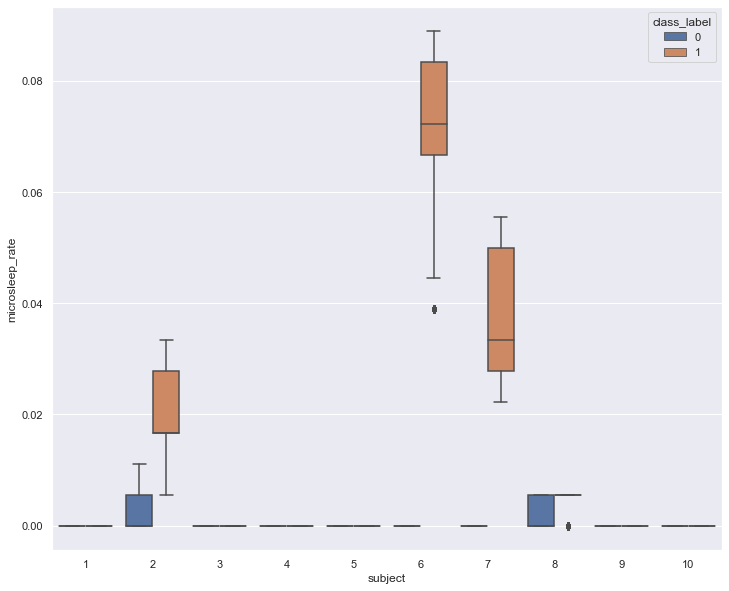

In [76]:
sns.boxplot(x='subject', y='microsleep_rate', data=df_aggregate, hue='class_label')

From the above plot, we can see that **for several subjects, microsleep_rate in class 1 is bigger than microsleep_rate in class 0**.

#### boxplot for yawning rate

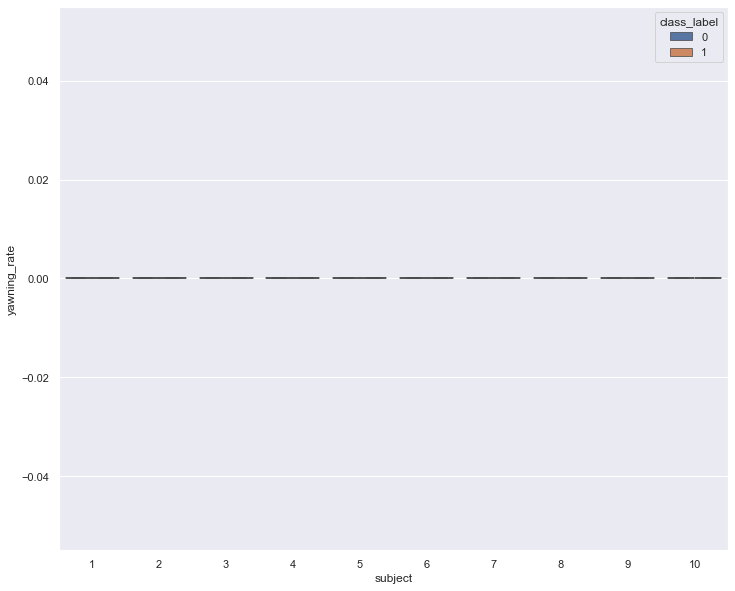

In [77]:
sns.boxplot(x='subject', y='yawning_rate', data=df_aggregate, hue='class_label')

From the above plot, we can see that **yawning_rate always zero for all subjects**. This kind of things may happen because of aspect ratio error or thresholding error so yawning is not detected. 

#### matrix correlation

In [78]:
sns.set(rc={'figure.figsize':(8,6)})

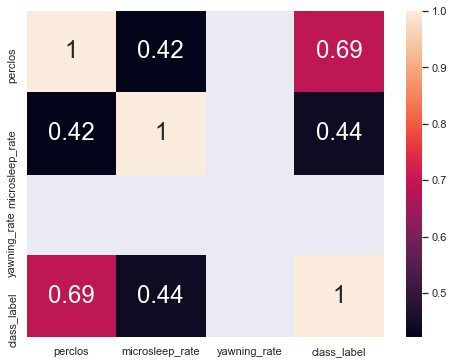

In [79]:
sns.heatmap(df_aggregate[['perclos','microsleep_rate','yawning_rate','class_label']].corr(), annot=True, annot_kws={'size':24})

From the above plot, we can see that the **new features have a better correlation with class_label**

#### drop unused feature

In [80]:
df_result = df_aggregate.drop(columns=['calc_eye_state','calc_mouth_state'])
df_result_identical_fps = df_aggregate_identical_fps.drop(columns=['calc_eye_state','calc_mouth_state'])

#### correlation of all variables

In [81]:
sns.set(rc={'figure.figsize':(18,16)})

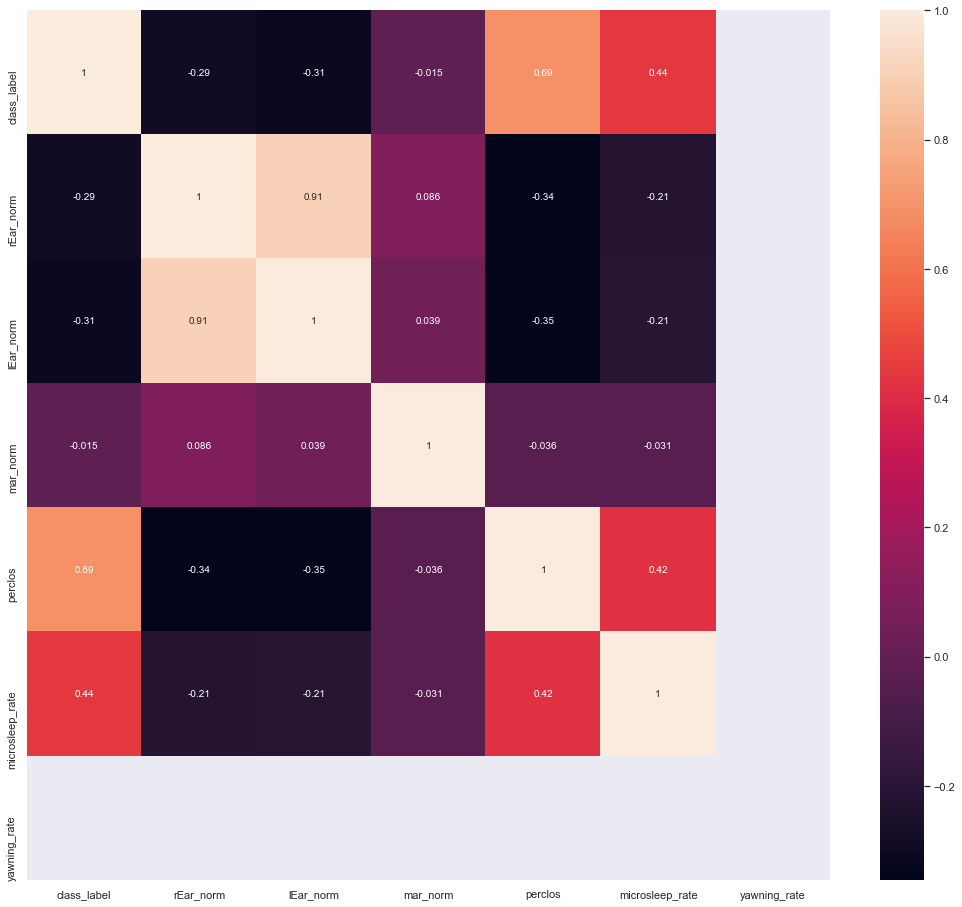

In [82]:
sns.heatmap(df_result[df_result.columns[2:]] .corr(), annot=True, annot_kws={'size':10})

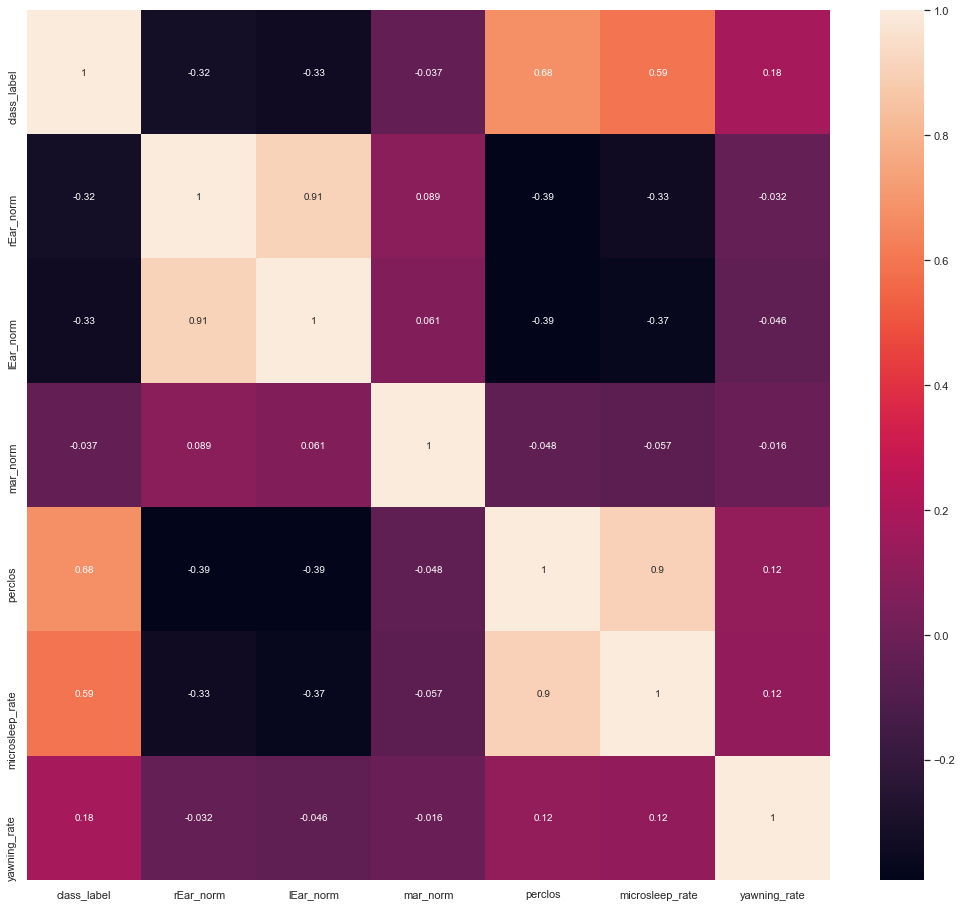

In [83]:
sns.heatmap(df_result_identical_fps[df_result_identical_fps.columns[2:]] .corr(), annot=True, annot_kws={'size':10})

## Save Data

In [84]:
fileName = f"transformed_data/{time.time()}_preprocessed-data"
print(f"filename is {fileName}")

filename is transformed_data/1592836941.1897974_preprocessed-data


In [86]:
df_result.to_csv(f"{fileName}.csv", index=False)
df_result_identical_fps.to_csv(f"{fileName}-identical_fps.csv", index=False)